In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy 
from pathlib import Path
import math
from utils import *


In [2]:
beta = 10

data_folder = Path('./Duffing_beta'+str(beta))
pts_file = data_folder/'Duffing_pts_ellip.csv'
tri_file = data_folder/'Duffing_tri_ellip.csv'
q_file = str(data_folder)+'/'+'Duffing_committor_beta'+str(beta)+'_ellip.csv'
qminus_file = str(data_folder)+'/'+'Duffing_backward_committor_beta'+str(beta)+'_ellip.csv'

data_pts = np.loadtxt(pts_file, delimiter=',', dtype=float)
data_q = np.loadtxt(q_file, delimiter=',', dtype=float)
data_qminus = np.loadtxt(qminus_file,delimiter=',', dtype=float)
data_pts_minus = np.hstack((data_pts[:,0][:,None],-data_pts[:,1][:,None]))

pts = torch.tensor(data_pts,dtype = torch.float32)
pts_minus = torch.tensor(data_pts_minus,dtype = torch.float32)
q_fem = torch.tensor(data_q[:,2],dtype = torch.float32)
qminus_fem = torch.tensor(data_qminus[:,2],dtype = torch.float32)

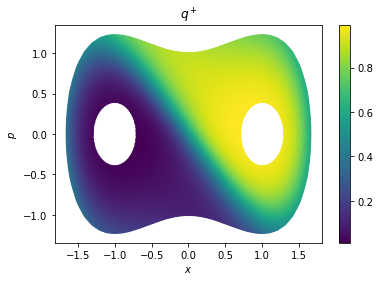

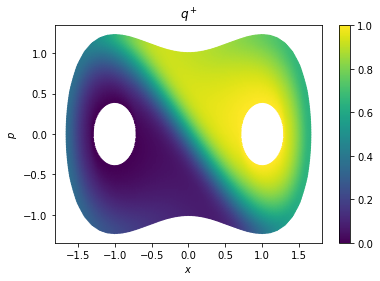

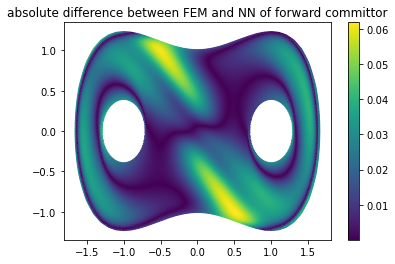

absolute MAE for forward committor when beta = 10 is: 0.0199
absolute RMSE for forward committor when beta = 10 is: 0.0247


In [3]:
model = torch.load('./data/Duffiing_gamma0.5_beta'+str(beta)+'_PINN.pt') 
model.eval()
q_NN = model(pts)

plt.scatter(data_pts[:,0], data_pts[:,1],c = q_NN.detach().numpy(), s = 2)
# plt.title('estimated committor by NN')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$p$')
plt.title('$q^+$')
# plt.savefig(str(data_folder)+'/'+'forward_NN_beta'+str(beta)+'_ellip.pdf')
plt.show()

plt.scatter(data_pts[:,0], data_pts[:,1],c = q_fem.detach().numpy(), s = 2)

plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$p$')
plt.title('$q^+$')
# plt.savefig(str(data_folder)+'/'+'forward_FEM_beta'+str(beta)+'_ellip.pdf')
plt.show()

plt.scatter(data_pts[:,0], data_pts[:,1],
           c = torch.abs(q_fem[:,None] - q_NN).detach().numpy(), s = 2)
plt.title('absolute difference between FEM and NN of forward committor')
plt.colorbar()
plt.show()

MAE = torch.mean(torch.abs(q_NN - q_fem[:,None]))
RMSE = torch.sqrt(torch.mean((q_NN - q_fem[:,None])**2))
print('absolute MAE for forward committor when beta = {} is: {:.4f}'.format(beta, MAE))
print('absolute RMSE for forward committor when beta = {} is: {:.4f}'.format(beta, RMSE))


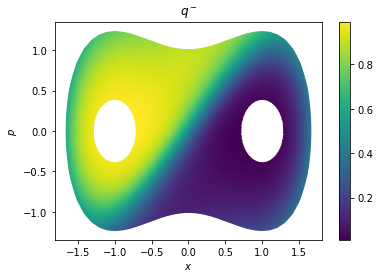

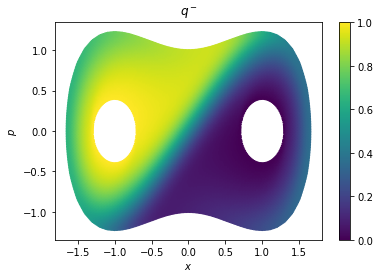

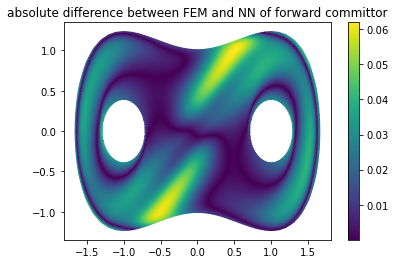

absolute MAE for backward committor when beta = 10 is: 0.0199
absolute RMSE for backward committor when beta = 10 is: 0.0247


In [4]:
# Compare the result of backward committor function
qminus_NN = torch.tensor(1) - model(pts_minus)

plt.scatter(data_pts[:,0], data_pts[:,1],c = qminus_NN.detach().numpy(), s = 2)
# plt.title('estimated committor by NN')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$p$')
plt.title('$q^-$')
plt.savefig(str(data_folder)+'/'+'backward_NN_beta'+str(beta)+'_ellip.pdf')
plt.show()

plt.scatter(data_pts[:,0], data_pts[:,1],c = qminus_fem.detach().numpy(), s = 2)
# plt.title('estimated committor by FEM')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$p$')
plt.title('$q^-$')
plt.savefig(str(data_folder)+'/'+'backward_FEM_beta'+str(beta)+'_ellip.pdf')
plt.show()

plt.scatter(data_pts[:,0], data_pts[:,1],
           c = torch.abs(qminus_fem[:,None] - qminus_NN).detach().numpy(), s = 2)
plt.title('absolute difference between FEM and NN of forward committor')
plt.colorbar()
plt.show()

MAE = torch.mean(torch.abs(qminus_NN - qminus_fem[:,None]))
RMSE = torch.sqrt(torch.mean((qminus_NN - qminus_fem[:,None])**2))
print('absolute MAE for backward committor when beta = {} is: {:.4f}'.format(beta, MAE))
print('absolute RMSE for backward committor when beta = {} is: {:.4f}'.format(beta, RMSE))

In [5]:
Funs = functions(torch.tensor(-1), torch.tensor(1))
gamma = torch.tensor(0.5)
betaT = torch.tensor(beta)

U = Funs.funU(pts[:,0]) # potential energy function
T = Funs.funT(pts[:,1]) # kinetic energy function

normal_Z = torch.sum(torch.exp(-betaT*(U+T))*q_fem*qminus_fem)
mR = torch.exp(-betaT*(U+T))*q_fem*qminus_fem/normal_Z


In [8]:
diff = torch.abs(q_fem - q_NN.squeeze())
Weighted_MAE = torch.sum(mR*diff)
Weighted_RMSE = torch.sqrt(torch.sum(mR*diff.pow(2)))

print('wMAE for forward committor when beta = {} is: {:.4f}'.format(beta, Weighted_MAE))
print('wRMSE for forward committor when beta = {} is: {:.4f}'.format(beta, Weighted_RMSE))

diff_minus = torch.abs(qminus_fem - qminus_NN.squeeze())
Weighted_MAE = torch.sum(mR*diff_minus)
Weighted_RMSE = torch.sqrt(torch.sum(mR*diff_minus.pow(2)))

print('wMAE for backward committor when beta = {} is: {:.4f}'.format(beta, Weighted_MAE))
print('wRMSE for backward committor when beta = {} is: {:.4f}'.format(beta, Weighted_RMSE))

wMAE for forward committor when beta = 10 is: 0.0158
wRMSE for forward committor when beta = 10 is: 0.0202
wMAE for backward committor when beta = 10 is: 0.0176
wRMSE for backward committor when beta = 10 is: 0.0221


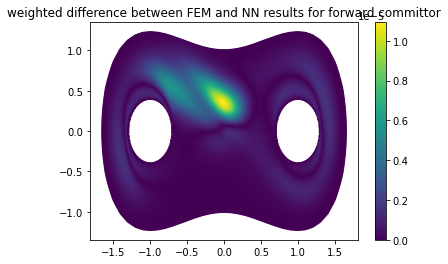

In [9]:
plt.scatter(data_pts[:,0], data_pts[:,1],
           c = torch.abs(mR*diff).detach().numpy(), s = 2)
plt.title('weighted difference between FEM and NN results for forward committor')
plt.colorbar()
plt.show()

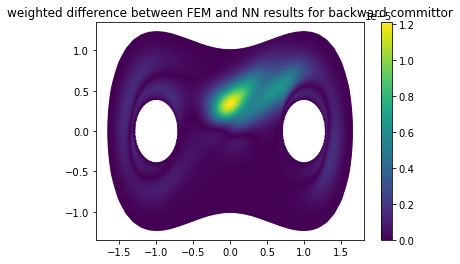

In [10]:
plt.scatter(data_pts[:,0], data_pts[:,1],
           c = torch.abs(mR*diff_minus).detach().numpy(), s = 2)
plt.title('weighted difference between FEM and NN results for backward committor')
plt.colorbar()
plt.show()